Based on: 

https://www.kaggle.com/stutisehgal/preeni-data-science-assignment

https://www.kaggle.com/manmandes/initial-nsl-kdd

In [80]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder

Data extraction

In [48]:
# fetch the training file
file_path_train = './dataset/KDDTrain+.txt'
file_path_test = './dataset/KDDTest+.txt' 

df_train = pd.read_csv(file_path_train, header=None)
df_test = pd.read_csv(file_path_test, header=None)

df_train

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20


In [49]:
# add the column labels
df_train.columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df_test.columns = df_train.columns

In [50]:
class_DoS = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 
                'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
class_Probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']

class_U2R = ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']

class_R2L = ['ftp_write', 'guess_passwd', 'httptunnel',  'imap', 'multihop', 'named', 
            'phf', 'sendmail', 'snmpgetattack', 'spy', 'snmpguess', 'warezclient', 
            'warezmaster', 'xlock', 'xsnoop']

In [76]:
np.unique(df_train['attack'])

array(['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap',
       'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap',
       'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan',
       'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster'],
      dtype=object)

In [77]:
len(np.unique(df_train['attack']))

23

In [78]:
np.unique(df_test['attack'])

array(['apache2', 'back', 'buffer_overflow', 'ftp_write', 'guess_passwd',
       'httptunnel', 'imap', 'ipsweep', 'land', 'loadmodule', 'mailbomb',
       'mscan', 'multihop', 'named', 'neptune', 'nmap', 'normal', 'perl',
       'phf', 'pod', 'portsweep', 'processtable', 'ps', 'rootkit',
       'saint', 'satan', 'sendmail', 'smurf', 'snmpgetattack',
       'snmpguess', 'sqlattack', 'teardrop', 'udpstorm', 'warezmaster',
       'worm', 'xlock', 'xsnoop', 'xterm'], dtype=object)

In [79]:
len(np.unique(df_test['attack']))

38

In [83]:
res = list((Counter(list(np.unique(df_test['attack'])))-Counter(list(np.unique(df_train['attack'])))).elements())
print(res)
print(len(res))

['apache2', 'httptunnel', 'mailbomb', 'mscan', 'named', 'processtable', 'ps', 'saint', 'sendmail', 'snmpgetattack', 'snmpguess', 'sqlattack', 'udpstorm', 'worm', 'xlock', 'xsnoop', 'xterm']
17


In [84]:
res = list((Counter(list(np.unique(df_train['attack'])))-Counter(list(np.unique(df_test['attack'])))).elements())
print(res)
print(len(res))

['spy', 'warezclient']
2


Data transformation - The first transformations that we'll want to do are around the attack field. We'll start by adding a column that encodes 'normal' values as 0 and any other value as 1. We will use this as our classifier for a simple binary model that idenfities any attack.

In [51]:
df_train['class'] = df_train['attack']
df_train['class'].replace(class_DoS, value='DoS', inplace=True)
df_train['class'].replace(class_Probe, value='Probe',inplace=True)
df_train['class'].replace(class_U2R, value='U2R',inplace=True)
df_train['class'].replace(class_R2L, value='R2L', inplace=True)
print(df_train['class'].unique())

['normal' 'DoS' 'R2L' 'Probe' 'U2R']


In [52]:
df_test['class'] = df_test['attack']
df_test['class'].replace(class_DoS, value='DoS', inplace=True)
df_test['class'].replace(class_Probe, value='Probe',inplace=True)
df_test['class'].replace(class_U2R, value='U2R',inplace=True)
df_test['class'].replace(class_R2L, value='R2L', inplace=True)
print(df_test['class'].unique())

['DoS' 'normal' 'Probe' 'R2L' 'U2R']


In [53]:
df_train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20,DoS
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,21,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,18,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,20,DoS


In [54]:
df_train_obj = df_train.iloc[:, :-3].select_dtypes(include='object')
df_train_num = df_train.iloc[:, :-3].select_dtypes(exclude='object')

df_test_obj = df_test.iloc[:, :-3].select_dtypes(include='object')
df_test_num = df_test.iloc[:, :-3].select_dtypes(exclude='object')

In [55]:
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels, legend_string):
    list_length = len(data_list)
    
    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list): 
        
        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
       
        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])
        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title=legend_string,
                           loc="center left",
                           bbox_to_anchor=(0.8, -0.5, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])
        
    return axs   

In [56]:
def make_pies(dataset, a, b):
    
    a_vs_b = pd.crosstab(dataset[a], dataset[b])
    
    b_unique = np.unique(dataset[b])
    
    a_values = [a_vs_b[str(b_unique[i])] for i in range(len(b_unique))]
    
    bake_pies(a_values, b_unique, a)
    plt.show()

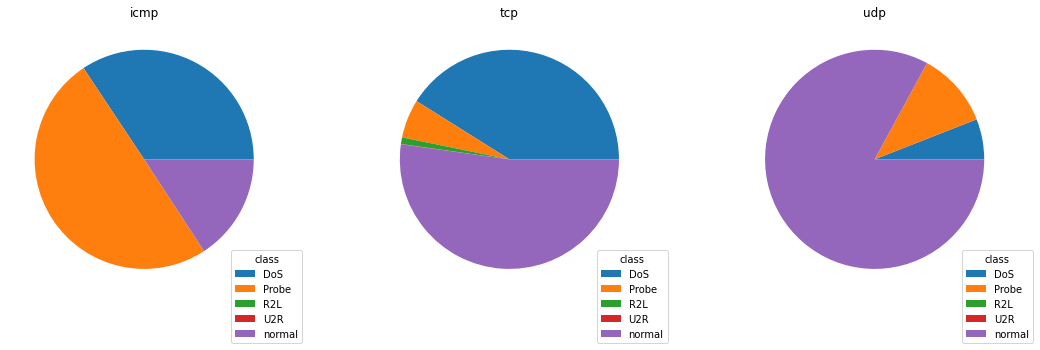

In [57]:
make_pies(df_train, "class", "protocol_type")

In [93]:
pd.crosstab(df_train['protocol_type'], df_train['class'], normalize='index')

class,DoS,Probe,R2L,U2R,normal
protocol_type,,,,,
icmp,0.343384,0.498734,0.000000,0.000000,0.157882
tcp,0.410833,0.057036,0.009689,0.000477,0.521964
udp,0.059494,0.110985,0.000000,0.000200,0.829320


In [90]:
pd.crosstab(df_train['protocol_type'], df_train[df_train['class']!='normal']['class'], normalize='index')

class,DoS,Probe,R2L,U2R
protocol_type,,,,
icmp,0.407763,0.592237,0.000000,0.000000
tcp,0.859419,0.119314,0.020269,0.000998
udp,0.348574,0.650254,0.000000,0.001172


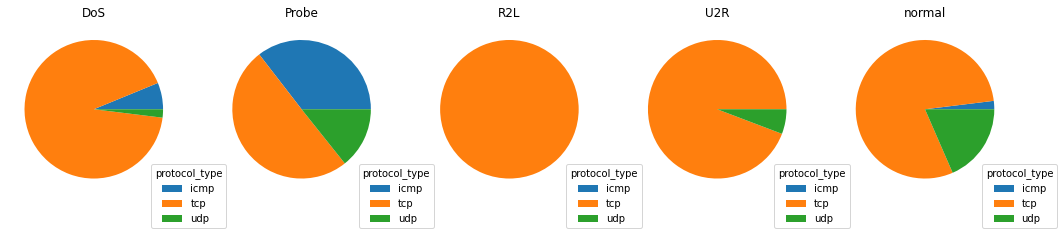

In [58]:
make_pies(df_train, "protocol_type", "class")

In [92]:
pd.crosstab(df_train['class'], df_train['protocol_type'], normalize='index')

protocol_type,icmp,tcp,udp
class,,,
DoS,0.061990,0.918588,0.019422
Probe,0.354753,0.502488,0.142759
R2L,0.000000,1.000000,0.000000
U2R,0.000000,0.942308,0.057692
normal,0.019438,0.795925,0.184637


In [89]:
pd.crosstab(df_train[df_train['class']!='normal']['class'], df_train['protocol_type'], normalize='index')

protocol_type,icmp,tcp,udp
class,,,
DoS,0.061990,0.918588,0.019422
Probe,0.354753,0.502488,0.142759
R2L,0.000000,1.000000,0.000000
U2R,0.000000,0.942308,0.057692


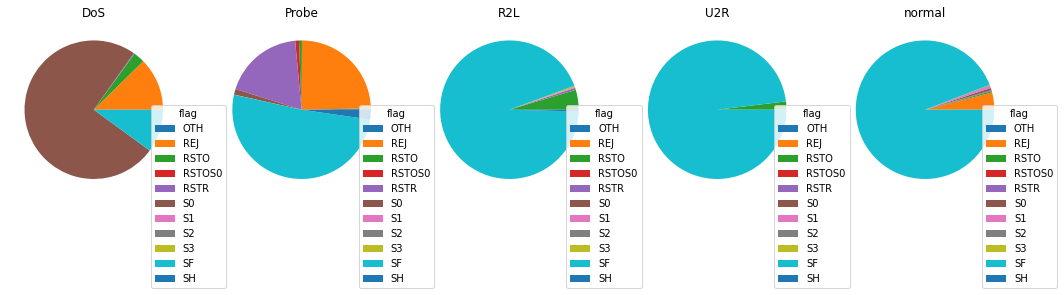

In [59]:
make_pies(df_train, "flag", "class")

In [94]:
pd.crosstab(df_train['class'], df_train['flag'], normalize='index')

flag,OTH,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
class,,,,,,,,,,,
DoS,0.000000,0.123479,0.026477,0.000000,0.001960,0.747795,0.000044,0.000109,0.000000,0.100137,0.000000
Probe,0.003003,0.246139,0.006863,0.008837,0.187028,0.013126,0.000086,0.000172,0.000086,0.511925,0.022735
R2L,0.000000,0.000000,0.046231,0.000000,0.005025,0.000000,0.001005,0.001005,0.003015,0.939698,0.004020
U2R,0.000000,0.000000,0.019231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.980769,0.000000
normal,0.000163,0.039989,0.003252,0.000000,0.002168,0.005257,0.005361,0.001767,0.000668,0.941345,0.000030


In [60]:
enc = OneHotEncoder(handle_unknown='ignore')
df_train_enc = enc.fit_transform(df_train_obj).toarray()
train_enc_features = enc.get_feature_names(input_features=df_train_obj.columns)
df_test_enc = enc.transform(df_test_obj).toarray()
test_enc_features = enc.get_feature_names(input_features=df_test_obj.columns)
X_train_enc = np.c_[df_train_num, df_train_enc]
X_test_enc = np.c_[df_test_num, df_test_enc]
print(f"X_train_enc shape: {X_train_enc.shape}")
print(f"X_test_enc shape: {X_test_enc.shape}")

X_train_enc shape: (125973, 122)
X_test_enc shape: (22544, 122)


In [61]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_enc)
X_test = scaler.transform(X_test_enc)

In [62]:
df_train['class'][10:20]

10       DoS
11       DoS
12    normal
13       R2L
14       DoS
15       DoS
16    normal
17     Probe
18    normal
19    normal
Name: class, dtype: object

In [63]:
le = LabelEncoder()
y_train = le.fit_transform(df_train['class'])
y_test = le.transform(df_test['class'])

np.unique(y_train)

array([0, 1, 2, 3, 4])

In [64]:
y_train[10:20]

array([0, 0, 4, 2, 0, 0, 4, 1, 4, 4])

In [65]:
X_train = X_train.reshape(len(X_train), 122)
X_test = X_test.reshape(len(X_test), 122)

In [66]:
# train = np.append(X_train,y_train, axis=1)
# df_train = pd.DataFrame(data=train)
# df_train.iloc[: , -1]= df_train.iloc[: , -1].astype('int')

# df_train.to_csv('dataset/kdd_train2.csv', index=False)

# test = np.append(X_test,y_test, axis=1)
# df_test = pd.DataFrame(data=test)
# df_test.iloc[: , -1]= df_test.iloc[: , -1].astype('int')
# df_test.to_csv('dataset/kdd_test2.csv', index=False)

/home/beata/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


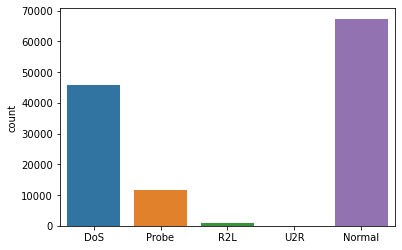

In [67]:
g = sns.countplot(y_train)
g.set_xticklabels(["DoS", "Probe", "R2L", "U2R", "Normal"])
plt.show()

In [71]:
pd.DataFrame(y_train).value_counts(normalize=True) * 100

4    53.458281
0    36.457812
1     9.252776
2     0.789852
3     0.041279
dtype: float64

/home/beata/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


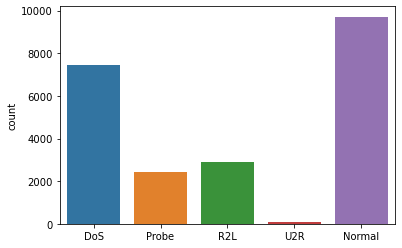

In [68]:
g = sns.countplot(y_test)
g.set_xticklabels(["DoS", "Probe", "R2L", "U2R", "Normal"])
plt.show()

In [73]:
pd.DataFrame(y_test).value_counts(normalize=True) * 100

4    43.075763
0    33.090845
2    12.797197
1    10.738999
3     0.297197
dtype: float64